In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(0)
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os

# Diagnosis & Parameters

In [2]:
diagnosis = 'death'

In [3]:
parameters = {
    'dx_offset' : 60,
    'pos_examples' : 5000,
    'neg_examples' : 5000,
    'ratio' : .5,           #pos/all
    'seq_length' : 150,
    'vocab_size' : 1000,
    'window' : [60*4, 60*0],
    'baseline' : [0, 360],
}

print(parameters['window'])

data_path = '/Users/tobymanders/Documents/insight_project/data/'
image_path = '/Users/tobymanders/Documents/insight_project/figures/'

[240, 0]


# Functions

In [4]:
def save_fig(fig_name, tight_layout=True):
    path = os.path.join(image_path, fig_name + '.png')
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
def check_col_complete(dataframe):
    len_ = len(dataframe)

    incomplete = []
    for col in dataframe.columns:
        complete = dataframe[col].count() == len_
        if complete:
            print('{: >23}: COMPLETE'.format(col))
        else:
            missing = len_ - dataframe[col].count()
            incomplete.append(col)
            print('{: >23}: MISSING {} VALUES ({:.1f}%)'.format(col, missing, missing*100/len_))
    
    print('\nTotal number of items:', len_)

    return incomplete

In [6]:
def tokenize_text(x):
    tokenized = [word_to_ID[word] if word in word_to_ID else 
                                         word_to_ID['<unk>'] for word in x.split(';')]
    return tokenized
            

In [7]:
def pad_text(x):
    rem = parameters['seq_length'] - len(x)
    if rem > 0:
        pad = [word_to_ID['<unk>']]*abs(rem)
        x.extend(pad)
        return x
    else:
        return x[-parameters['seq_length']:]
    

# Clean and Preprocess Features

In [192]:
df_merged = pd.read_csv('../data/saved_data/death8392_8392240_merged_data.csv')

In [193]:
from ast import literal_eval
df_merged['dx_seq_tok'] = df_merged['dx_seq_tok'].apply(lambda x: literal_eval(x))

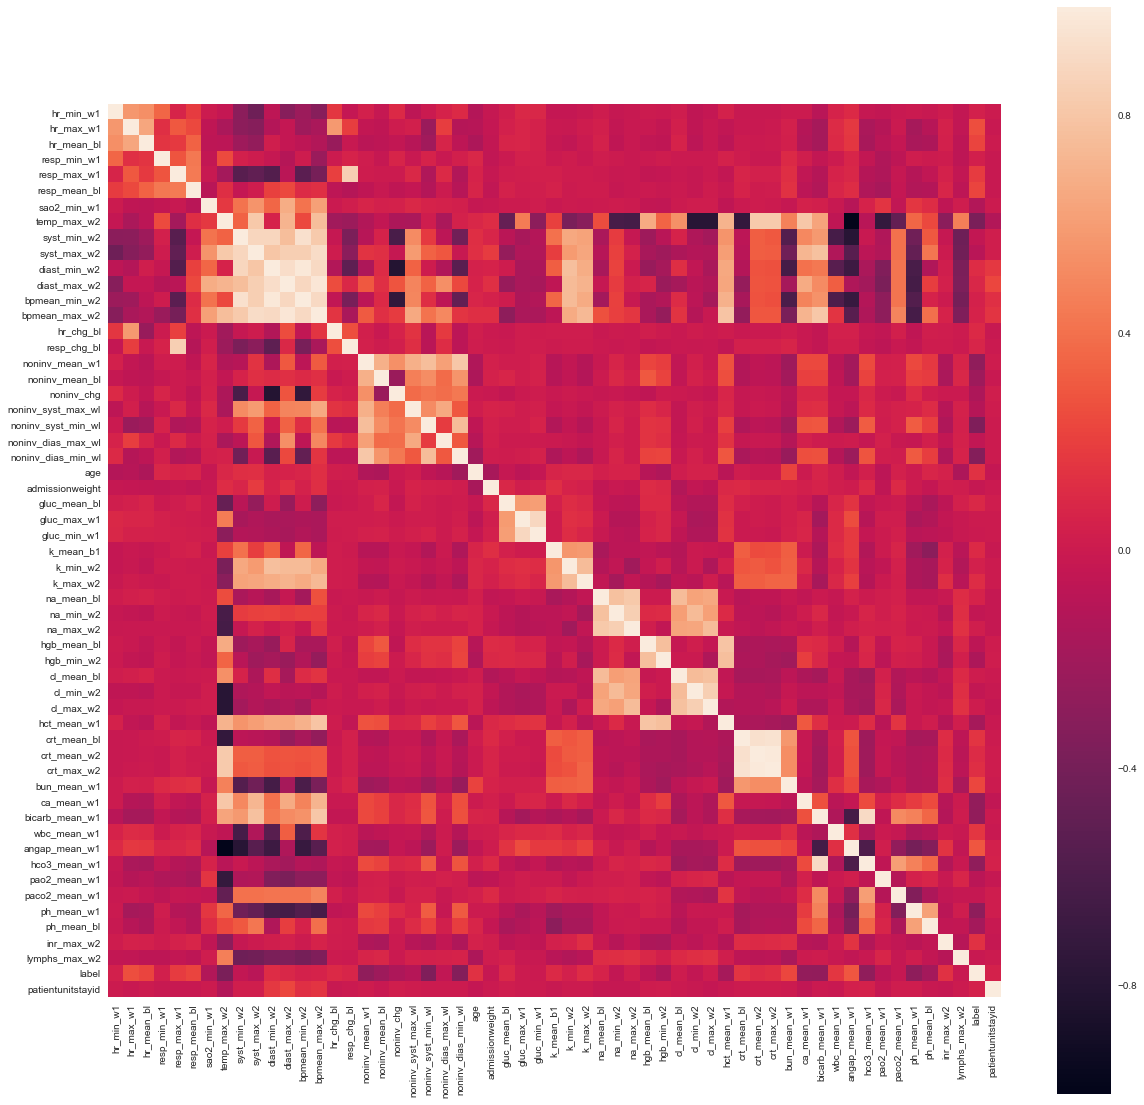

In [196]:
import seaborn as sns

corrmat = df_merged.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, square=True);


In [198]:
cols

Index(['label', 'angap_mean_w1', 'hr_max_w1', 'bun_mean_w1', 'resp_mean_bl',
       'hr_mean_bl', 'resp_max_w1', 'wbc_mean_w1', 'crt_mean_bl', 'inr_max_w2',
       'age', 'crt_max_w2', 'k_max_w2', 'diast_min_w2', 'crt_mean_w2',
       'hr_chg_bl', 'k_mean_b1', 'gluc_mean_bl', 'diast_max_w2',
       'resp_chg_bl'],
      dtype='object')

In [201]:
df_merged[cols].values.T

array([[True, False, False, ..., False, True, True],
       [nan, 13.0, nan, ..., nan, 13.0, nan],
       [nan, 112.0, 124.0, ..., 109.0, 103.0, 117.0],
       ...,
       [nan, 145.0, 101.0, ..., 89.6, 282.2, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, 2.612244897959183, 12.042857142857144, ...,
        7.791044776119403, 1.4507042253521119, 11.507042253521126]],
      dtype=object)

In [206]:
df_num_cat = df_merged.drop(['dx_seq_tok', 'patientunitstayid', 'unittype', 'label'], axis=1)

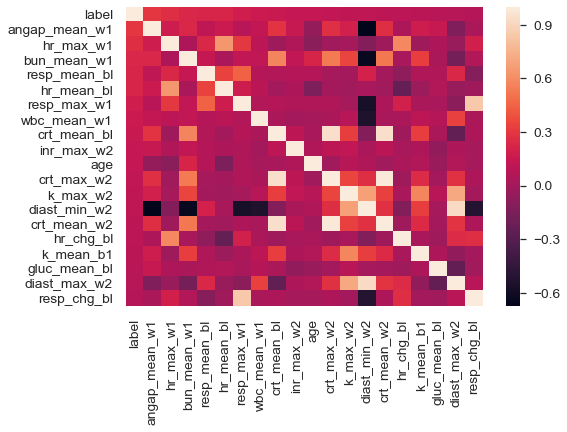

In [218]:
smallmat = df_merged[cols].corr()
sns.heatmap(smallmat)

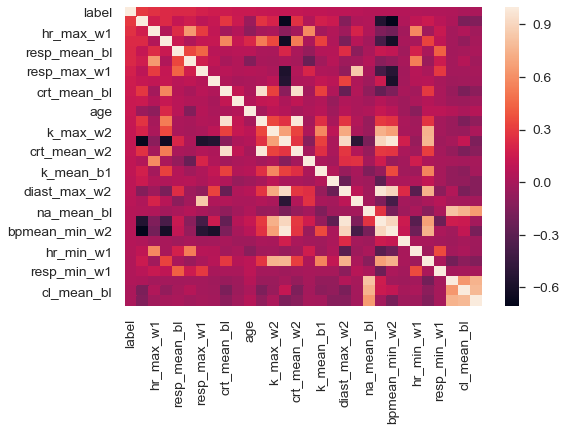

In [219]:
num_variables = 30
cols = corrmat.nlargest(num_variables, 'label')['label'].index
smallmat = df_merged[cols].corr()
sns.heatmap(smallmat)

In [191]:
check_col_complete(df_merged);

             dx_seq_tok: COMPLETE
                 gender: COMPLETE
               unittype: COMPLETE
        unitadmitsource: COMPLETE
              ethnicity: COMPLETE
              hr_min_w1: COMPLETE
              hr_max_w1: COMPLETE
             hr_mean_bl: COMPLETE
            resp_min_w1: COMPLETE
            resp_max_w1: COMPLETE
           resp_mean_bl: COMPLETE
            sao2_min_w1: COMPLETE
            temp_max_w2: MISSING 11344 VALUES (99.9%)
              hr_chg_bl: COMPLETE
            resp_chg_bl: COMPLETE
         noninv_mean_w1: COMPLETE
         noninv_mean_bl: COMPLETE
             noninv_chg: COMPLETE
     noninv_syst_max_wl: MISSING 17 VALUES (0.1%)
     noninv_syst_min_wl: MISSING 17 VALUES (0.1%)
     noninv_dias_max_wl: MISSING 17 VALUES (0.1%)
     noninv_dias_min_wl: MISSING 17 VALUES (0.1%)
                    age: COMPLETE
        admissionweight: MISSING 291 VALUES (2.6%)
           gluc_mean_bl: MISSING 3347 VALUES (29.5%)
            gluc_max_w1: MISSI

In [137]:
len(df_merged.dropna(subset=['noninv_mean_bl', 'resp_mean_bl', 'hr_max_w1', 
                             'sao2_min_w1', 'resp_chg_bl', 'noninv_chg']))

11350

In [142]:
df_merged = df_merged.dropna(subset=['noninv_mean_bl', 'resp_mean_bl', 'hr_max_w1', 
                             'sao2_min_w1', 'resp_chg_bl', 'noninv_chg'])

In [143]:
df_merged.columns

Index(['dx_seq_tok', 'gender', 'unittype', 'unitadmitsource', 'ethnicity',
       'hr_min_w1', 'hr_max_w1', 'hr_mean_bl', 'resp_min_w1', 'resp_max_w1',
       'resp_mean_bl', 'sao2_min_w1', 'temp_max_w2', 'syst_min_w2',
       'syst_max_w2', 'diast_min_w2', 'diast_max_w2', 'bpmean_min_w2',
       'bpmean_max_w2', 'hr_chg_bl', 'resp_chg_bl', 'noninv_mean_w1',
       'noninv_mean_bl', 'noninv_chg', 'noninv_syst_max_wl',
       'noninv_syst_min_wl', 'noninv_dias_max_wl', 'noninv_dias_min_wl', 'age',
       'admissionweight', 'gluc_mean_bl', 'gluc_max_w1', 'gluc_min_w1',
       'k_mean_b1', 'k_min_w2', 'k_max_w2', 'na_mean_bl', 'na_min_w2',
       'na_max_w2', 'hgb_mean_bl', 'hgb_min_w2', 'cl_mean_bl', 'cl_min_w2',
       'cl_max_w2', 'hct_mean_w1', 'crt_mean_bl', 'crt_mean_w2', 'crt_max_w2',
       'bun_mean_w1', 'ca_mean_w1', 'bicarb_mean_w1', 'wbc_mean_w1',
       'angap_mean_w1', 'hco3_mean_w1', 'pao2_mean_w1', 'paco2_mean_w1',
       'ph_mean_w1', 'ph_mean_bl', 'inr_max_w2', 'lymphs_m

In [144]:
##### IMPORTANT: FITTING TEMPORARILY OFF

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

cat_attribs = ['gender', 'unittype', 'unitadmitsource', 'ethnicity']
num_attribs = ['hr_min_w1', 'hr_max_w1', 'hr_mean_bl',
       'resp_min_w1', 'resp_max_w1', 'resp_mean_bl', 'sao2_min_w1',
       'temp_max_w2', 'hr_chg_bl',
       'resp_chg_bl', 'noninv_mean_w1', 'noninv_mean_bl',
       'noninv_chg', 'noninv_syst_max_wl', 'noninv_syst_min_wl',
       'noninv_dias_max_wl', 'noninv_dias_min_wl', 'age', 'admissionweight',
       'gluc_mean_bl', 'gluc_max_w1', 'gluc_min_w1', 'k_mean_b1', 'k_min_w2',
       'k_max_w2', 'na_mean_bl', 'na_min_w2', 'na_max_w2', 'hgb_mean_bl',
       'hgb_min_w2', 'cl_mean_bl', 'cl_min_w2', 'cl_max_w2', 'hct_mean_w1',
       'crt_mean_bl', 'crt_mean_w2', 'crt_max_w2', 'bun_mean_w1', 'ca_mean_w1',
       'bicarb_mean_w1', 'wbc_mean_w1', 'angap_mean_w1', 'hco3_mean_w1',
       'pao2_mean_w1', 'paco2_mean_w1', 'ph_mean_w1', 'ph_mean_bl',
       'inr_max_w2', 'lymphs_max_w2']


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("cat", cat_encoder, cat_attribs),
        ("num", num_pipeline, num_attribs)],
        remainder='passthrough'
    )

full_pipeline = pkl.load(open('../models/full_pipeline.pkl', 'rb'))

df_merged['patientunitstayid'] = df_merged.index
final_cols = ['dx_seq_tok'] + cat_attribs + num_attribs + ['label'] + ['patientunitstayid']
df_merged = df_merged[final_cols]
df_merged.dropna(subset=cat_attribs, inplace=True)
# full_pipeline.fit(df_merged)
df_merged_prepared = full_pipeline.transform(df_merged,)

In [145]:
# # Save pipeline
# import pickle as pkl
# pkl.dump(full_pipeline, open('../models/full_pipeline.pkl', 'wb'))

# ML

In [146]:
y = df_merged_prepared[:, -2].astype(int)

In [147]:
np.mean(y)

0.4952422907488987

In [148]:
# Stratified split

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(df_merged_prepared[:, :-2], y):
    X_train, X_test = df_merged_prepared[:, :-2][train_index], df_merged_prepared[:, :-2][test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for train_index, test_index in sss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

In [149]:
X_train.shape

(7264, 80)

In [150]:
X_train_A, X_train_B = np.array(list(X_train[:,-1])), X_train[:,:-1].astype(float)
X_test_A, X_test_B = np.array(list(X_test[:,-1])), X_test[:,:-1].astype(float)
X_val_A, X_val_B = np.array(list(X_val[:,-1])), X_val[:,:-1].astype(float)

In [151]:
X_train_B

array([[ 0.        ,  1.        ,  0.        , ...,  0.21118137,
        -0.22223307, -0.19547908],
       [ 0.        ,  1.        ,  0.        , ..., -0.31298798,
        -0.327436  , -0.19547908],
       [ 1.        ,  0.        ,  0.        , ..., -2.40966539,
        -0.22223307,  0.9466833 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -1.50547326,
        -0.22223307, -0.19547908],
       [ 0.        ,  1.        ,  0.        , ...,  1.32504125,
        -0.22223307, -0.56668185],
       [ 1.        ,  0.        ,  0.        , ...,  0.08013904,
        -0.22223307,  0.56596251]])

In [152]:
np.mean(y_test)

0.4951541850220264

## Model 1: DNN

In [222]:
tf.keras.backend.clear_session()


model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC()])

es1 = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

# Numcat only
history1 = model_1.fit(X_train_B,
                    y_train,
                    epochs=200,
                    batch_size=2048,
                    validation_data=(X_val_B, y_val),
                    callbacks=[es1], verbose=0)

In [223]:
results = model_1.evaluate(X_test_B, y_test, verbose=0)
print(results)

[0.5620269822916796, 0.8345506]


In [155]:
# # Numcat only
y_pred1 = model_1.predict(X_test_B, batch_size=5000).ravel()

In [156]:
y_train.shape

(7264,)

In [157]:
X_train_A.shape

(7264, 150)

## Model 2: RNN

In [158]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(32),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(rate=0.4),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [159]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(parameters['vocab_size'], 32),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(rate=0.4),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [160]:
# parameters['vocab_size'] = 1000

In [161]:

# tf.keras.backend.clear_session()

# input_A = tf.keras.layers.Input(shape=(parameters['seq_length'],), name='seq_input')
# embedding = tf.keras.layers.Embedding(parameters['vocab_size'], 32)(input_A)
# hidden1_A = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(embedding)
# hidden_drop = tf.keras.layers.Dropout(rate=0.3)(hidden1_A)
# hidden2_A = tf.keras.layers.Dense(32, activation='relu')(hidden_drop)

# input_B = tf.keras.layers.Input(shape=(X_train_B.shape[1],), name='feature_input')
# hidden1_B = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01))(input_B)
# hidden_drop1B = tf.keras.layers.Dropout(rate=0.3)(hidden1_B)
# hidden2_B = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01))(hidden_drop1B)

# concat = tf.keras.layers.Concatenate()([hidden2_A, hidden2_B])
# common = tf.keras.layers.Dense(64, activation='relu')(concat)
# drop = tf.keras.layers.Dropout(rate=0.3)(common)
# output = tf.keras.layers.Dense(1, name="output", activation='sigmoid')(drop)
# aux_output = tf.keras.layers.Dense(1, activation='sigmoid', name="aux_output")(hidden1_B)

# model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [162]:
# model.compile(loss=['binary_crossentropy','binary_crossentropy'],
#               optimizer='adam',
#               loss_weights=[0.9, 0.1],
#               metrics=[tf.keras.metrics.AUC(), 'accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=[tf.keras.metrics.AUC()])

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [163]:
# model.summary()

In [164]:
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [165]:
# # Full model
# history = model.fit([X_train_A, X_train_B],
#                     [y_train, y_train],
#                     epochs=30,
#                     batch_size=1024,
#                     validation_data=([X_val_A, X_val_B], [y_val, y_val]),
#                     callbacks=[es], verbose=0)

In [166]:
# # Full model
# results = model.evaluate([X_test_A, X_test_B], [y_test, y_test], verbose=0)
# print(results)

In [167]:
# import matplotlib.pyplot as plt

# def plot_graphs(history, string):
#     plt.plot(history.history[string])
#     plt.plot(history.history['val_'+string])
#     plt.xlabel("Epochs")
#     plt.ylabel(string)
#     plt.legend([string, 'val_'+string])
#     plt.title(f'Epoch vs. {string}')

In [168]:
# auc = list(history.history.keys())[3]
# history.history.keys()

In [169]:
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plot_graphs(history, auc)

# plt.subplot(1,2,2)
# plot_graphs(history, 'loss')

# fig_name = diagnosis + str(len(dx_events)) + '_' + str(len(dx_nonevents)) + 'epochs_vs_accuracy'
# save_fig(fig_name)

In [170]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

# y_pred = model.predict([X_test_A, X_test_B], batch_size=5000)[0].ravel()
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
# auc_keras = auc(fpr_keras, tpr_keras)

# plt.style.use('seaborn')
# plt.figure(figsize=(8,8))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
# plt.legend(loc='best')
# plt.title('ROC Curve')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')

# fig_name = diagnosis + str(len(dx_events)) + '_' + str(len(dx_nonevents)) + 'AUC' + '{:.3f}'.format(auc_keras)
# save_fig(fig_name)

In [171]:



model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(parameters['vocab_size'], 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC()])


es2 = EarlyStopping(monitor='val_auc_1', mode='max', patience=5, restore_best_weights=True)


# Sequential only
history2 = model_2.fit(X_train_A,
                    y_train,
                    epochs=30,
                    batch_size=1024,
                    validation_data=(X_val_A, y_val),
                    callbacks=[es2])

Train on 7264 samples, validate on 1816 samples
Epoch 1/30
7264/7264 [==============================] - 8s 1ms/sample - loss: 0.6911 - auc_1: 0.5938 - val_loss: 0.6844 - val_auc_1: 0.7095
Epoch 2/30
7264/7264 [==============================] - 3s 473us/sample - loss: 0.6781 - auc_1: 0.7067 - val_loss: 0.6610 - val_auc_1: 0.7341
Epoch 3/30
7264/7264 [==============================] - 3s 477us/sample - loss: 0.6478 - auc_1: 0.7292 - val_loss: 0.6207 - val_auc_1: 0.7449
Epoch 4/30
7264/7264 [==============================] - 4s 485us/sample - loss: 0.6105 - auc_1: 0.7362 - val_loss: 0.6010 - val_auc_1: 0.7523
Epoch 5/30
7264/7264 [==============================] - 3s 475us/sample - loss: 0.5953 - auc_1: 0.7453 - val_loss: 0.5875 - val_auc_1: 0.7585
Epoch 6/30
7264/7264 [==============================] - 3s 465us/sample - loss: 0.5775 - auc_1: 0.7557 - val_loss: 0.5818 - val_auc_1: 0.7639
Epoch 7/30
7264/7264 [==============================] - 3s 456us/sample - loss: 0.5683 - auc_1: 0.7655

In [172]:
results = model_2.evaluate(X_test_A, y_test, verbose=0)
print(results)

[0.5701188239757184, 0.7717677]


In [173]:
# # Numcat only
y_pred2 = model_2.predict(X_test_A, batch_size=5000).ravel()

In [174]:
# Remove last layer of models

model_1.pop()
model_2.pop()

## Model 3: DNN + RNN

In [185]:
input_A = tf.keras.layers.Input(shape=(parameters['seq_length'],), name='seq_input')
seq_model = model_2(input_A)

input_B = tf.keras.layers.Input(shape=(X_train_B.shape[1],), name='feature_input')
catnum_model = model_1(input_B)

concat = tf.keras.layers.Concatenate()([seq_model, catnum_model])
hidden1 = tf.keras.layers.Dense(32, activation='relu')(concat)
drop1 = tf.keras.layers.Dropout(rate=0.2)(hidden1)

output = tf.keras.layers.Dense(1, name="output", activation='sigmoid')(drop1)

model_3 = tf.keras.Model(inputs=[input_A, input_B], outputs=[output])

In [186]:
for layer in model_2.layers[:-1]:
    layer.trainable=True
    
for layer in model_1.layers[:-1]:
    layer.trainable=True

In [187]:
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])

In [188]:
model_3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
feature_input (InputLayer)      [(None, 79)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          87360       seq_input[0][0]                  
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          92800       feature_input[0][0]              
____________________________________________________________________________________________

In [189]:
es3 = EarlyStopping(monitor='val_auc_3', mode='max', patience=5, restore_best_weights=True)


history3 = model_3.fit([X_train_A, X_train_B],
                    y_train,
                    epochs=30,
                    batch_size=1024,
                    validation_data=([X_val_A, X_val_B],  y_val),
                    callbacks=[es3])

Train on 7264 samples, validate on 1816 samples
Epoch 1/30
7264/7264 [==============================] - 9s 1ms/sample - loss: 0.5517 - auc_3: 0.8195 - accuracy: 0.7350 - val_loss: 0.4480 - val_auc_3: 0.8790 - val_accuracy: 0.7985
Epoch 2/30
7264/7264 [==============================] - 3s 461us/sample - loss: 0.4301 - auc_3: 0.8892 - accuracy: 0.8117 - val_loss: 0.4590 - val_auc_3: 0.8806 - val_accuracy: 0.8029
Epoch 3/30
7264/7264 [==============================] - 3s 468us/sample - loss: 0.4093 - auc_3: 0.8974 - accuracy: 0.8216 - val_loss: 0.4437 - val_auc_3: 0.8803 - val_accuracy: 0.8012
Epoch 4/30
7264/7264 [==============================] - 4s 483us/sample - loss: 0.4038 - auc_3: 0.9005 - accuracy: 0.8194 - val_loss: 0.4499 - val_auc_3: 0.8797 - val_accuracy: 0.7930
Epoch 5/30
7264/7264 [==============================] - 3s 473us/sample - loss: 0.3943 - auc_3: 0.9047 - accuracy: 0.8287 - val_loss: 0.4499 - val_auc_3: 0.8791 - val_accuracy: 0.7952
Epoch 6/30
7264/7264 [============

In [190]:
results = model_3.evaluate([X_test_A, X_test_B], y_test, verbose=0)
print(results)

[0.4597500341841828, 0.8808046, 0.78370047]


In [181]:
# # Numcat only
y_pred3 = model_3.predict([X_test_A, X_test_B], batch_size=5000).ravel()

In [182]:
y_pred4 = y_pred3>0.5

In [183]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred4, y_test))

0.7788546255506608


Saving figure death11350AUC0.879


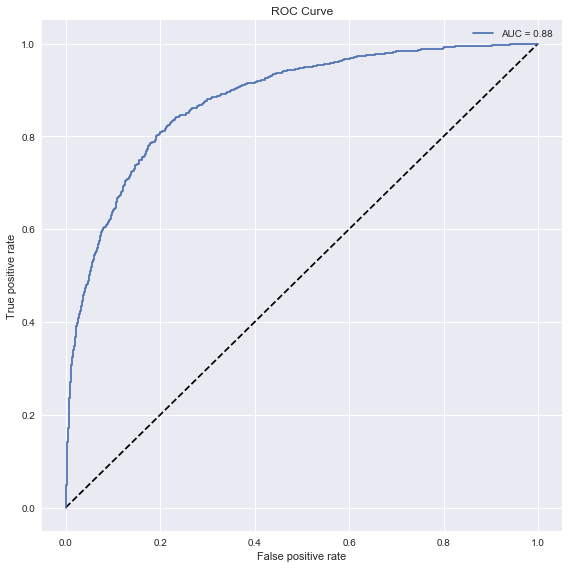

In [184]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred3)
auc_keras = auc(fpr_keras, tpr_keras)

plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.2f}'.format(auc_keras))
plt.legend(loc='best')
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

fig_name = diagnosis + str(len(df_merged)) + 'AUC' + '{:.3f}'.format(auc_keras)
save_fig(fig_name)